## 先用已有特征训练GBDT模型，然后利用GBDT模型学习到的树来构造新特征，最后把这些新特征加入原有特征一起训练模型。构造的新特征向量是取值0/1的，向量的每个元素对应于GBDT模型中树的叶子结点。当一个样本点通过某棵树最终落在这棵树的一个叶子结点上，那么在新特征向量中这个叶子结点对应的元素值为1，而这棵树的其他叶子结点对应的元素值为0。新特征向量的长度等于GBDT模型里所有树包含的叶子结点数之和。

## 举例说明,下面的图中的两棵树是GBDT学习到的，第一棵树有3个叶子结点，而第二棵树有2个叶子节点。对于一个输入样本点x，如果它在第一棵树最后落在其中的第二个叶子结点，而在第二棵树里最后落在其中的第一个叶子结点。那么通过GBDT获得的新特征向量为[0, 1, 0, 1, 0]，其中向量中的前三位对应第一棵树的3个叶子结点，后两位对应第二棵树的2个叶子结点。

## GBDT中需要多少棵树能达到效果最好呢？具体数字显然是依赖于实际应用以及拥有的数据量。一般数据量较少时，树太多会导致过拟合。另外，在建GBDT时也会对每棵树的叶子结点数做约束——比如不多于12个叶子结点。

<img src="http://i.imgur.com/fflZtpJ.png"
style="width:400px;height:400px">

xgboost自带接口：对原始数据以及测试数据进行new_feature= clf.predict(d_test, pred_leaf=True)即可得到一个(nsample, ntrees) 的结果矩阵，即每个样本在每个树上的index。

而对于sklearn的GBDT接口和xgbbost的xklearn接口，可以使用apply方法:clf.apply(x_test)

<img src="http://i.imgur.com/i9s2K3P.png"
style="width:700px;height:350px">

In [ ]:
#-- reference：
# Xinran He et al. Practical Lessons from Predicting Clicks on Ads at Facebook, 2014. 

# https://github.com/lytforgood/MachineLearningTrick

#Kaggle一个CTR预估比赛的冠军，代码可见https://github.com/guestwalk/kaggle-2014-criteo

In [1]:
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from sklearn import metrics
from sklearn.datasets  import  make_hastie_10_2
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

#准备数据，y本来是[-1:1],xgboost自带接口邀请标签是[0:1],把-1的转成1了。
X, y = make_hastie_10_2(random_state=0)
X = DataFrame(X)
y = DataFrame(y)
y.columns={"label"}
label={-1:0,1:1}
y.label=y.label.map(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)#划分数据集
y_train.head()

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,label
843,1
9450,0
7766,1
9802,1
8555,1


In [3]:
X.shape

(12000, 10)

In [6]:
#XGBoost自带接口
params={
    'eta': 0.3,
    'max_depth':3,   
    'min_child_weight':1,
    'gamma':0.3, 
    'subsample':0.8,
    'colsample_bytree':0.8,
    'booster':'gbtree',
    'objective': 'binary:logistic',
    'nthread':12,
    'scale_pos_weight': 1,
    'lambda':1,  
    'seed':27,
    'silent':0 ,
    'eval_metric': 'auc'
}

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)
d_test = xgb.DMatrix(X_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [7]:
model_bst = xgb.train(params, d_train, 30, watchlist, early_stopping_rounds=100, verbose_eval=10)

y_bst= model_bst.predict(d_test)

[0]	train-auc:0.609492	valid-auc:0.598046
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.939119	valid-auc:0.920489
[20]	train-auc:0.973886	valid-auc:0.958431


In [8]:
#sklearn接口
clf = XGBClassifier(
    n_estimators=30,#十棵树
    learning_rate =0.3,
    max_depth=3,
    min_child_weight=1,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=12,
    scale_pos_weight=1,
    reg_lambda=1,
    seed=27)


In [9]:
model_sklearn=clf.fit(X_train, y_train)

y_sklearn= clf.predict_proba(X_test)[:,1]

/usr/lib64/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib64/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
print("XGBoost_自带接口    AUC Score : %f" % metrics.roc_auc_score(y_test, y_bst))
print("XGBoost_sklearn接口 AUC Score : %f" % metrics.roc_auc_score(y_test, y_sklearn))

XGBoost_自带接口    AUC Score : 0.966531
XGBoost_sklearn接口 AUC Score : 0.966531


In [13]:
print "原始train大小：",X_train.shape
print "原始test大小：",X_test.shape

##XGBoost自带接口生成的新特征
train_new_feature= model_bst.predict(d_train, pred_leaf=True)
test_new_feature= model_bst.predict(d_test, pred_leaf=True)
train_new_feature1 = DataFrame(train_new_feature)
test_new_feature1 = DataFrame(test_new_feature)
print "新的特征集(自带接口)：",train_new_feature1.shape
print "新的测试集(自带接口)：",test_new_feature1.shape

#sklearn接口生成的新特征
train_new_feature= clf.apply(X_train)#每个样本在每颗树叶子节点的索引值
test_new_feature= clf.apply(X_test)
train_new_feature2 = DataFrame(train_new_feature)
test_new_feature2 = DataFrame(test_new_feature)

print "新的特征集(sklearn接口)：",train_new_feature2.shape
print "新的测试集(sklearn接口)：",test_new_feature2.shape  

原始train大小： (9600, 10)
原始test大小： (2400, 10)
新的特征集(自带接口)： (9600, 30)
新的测试集(自带接口)： (2400, 30)
新的特征集(sklearn接口)： (9600, 30)
新的测试集(sklearn接口)： (2400, 30)


In [14]:
train_new_feature1.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,8,11,9,9,10,8,11,12,9,9,...,10,8,10,11,9,10,10,8,11,12
1,10,11,9,11,11,9,11,12,9,9,...,10,9,11,11,9,10,10,8,11,13
2,10,11,9,12,10,9,11,12,9,9,...,10,9,14,11,10,13,10,8,11,13
3,10,11,9,10,10,9,11,14,9,9,...,8,9,11,12,9,10,10,8,13,12
4,12,11,9,9,10,7,11,12,9,10,...,10,8,13,11,9,10,10,8,12,12


In [15]:
#用两组新的特征分别训练，预测

#用XGBoost自带接口生成的新特征训练
new_feature1=clf.fit(train_new_feature1, y_train)
y_new_feature1= clf.predict_proba(test_new_feature1)[:,1]
#用XGBoost自带接口生成的新特征训练
new_feature2=clf.fit(train_new_feature2, y_train)
y_new_feature2= clf.predict_proba(test_new_feature2)[:,1]

print("XGBoost自带接口生成的新特征预测结果 AUC Score : %f" % metrics.roc_auc_score(y_test, y_new_feature1))
print("XGBoost自带接口生成的新特征预测结果 AUC Score : %f" % metrics.roc_auc_score(y_test, y_new_feature2))

XGBoost自带接口生成的新特征预测结果 AUC Score : 0.955561
XGBoost自带接口生成的新特征预测结果 AUC Score : 0.955561


In [17]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
onehot = OneHotEncoder(categorical_features='all')

In [38]:
train_onehot = onehot.transform(train_new_feature).toarray()
test_onehot = onehot.transform(test_new_feature).toarray()

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
#使用onehot新特征训练逻辑回归分类器
lr = LogisticRegression()
lr.fit(train_onehot,y_train)
yyyy = clf.predict_proba(test_onehot)[:,1]

print("XGBoost自带接口生成的新特征onehot预测结果 AUC Score : %f" % metrics.roc_auc_score(y_test,yyyy))


ValueError: feature_names mismatch: ['0 ', '1 ', '2 ', '3 ', '4 ', '5 ', '6 ', '7 ', '8 ', '9 ', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224']
expected 6 , 8 , 24, 25, 26, 27, 20, 21, 22, 23, 28, 29, 0 , 2 , 4 , 7 , 9 , 11, 10, 13, 12, 15, 14, 17, 16, 19, 18, 1 , 3 , 5  in input data
training data did not have the following fields: f169, f168, f161, f160, f163, f162, f165, f164, f167, f166, f6, f126, f41, f40, f43, f42, f45, f44, f47, f46, f49, f48, f208, f209, f217, f195, f196, f197, f118, f119, f114, f115, f116, f117, f110, f111, f112, f113, f56, f57, f54, f55, f52, f53, f50, f51, f193, f198, f199, f219, f59, f210, f0, f58, f109, f108, f107, f106, f105, f104, f103, f102, f101, f100, f187, f186, f185, f184, f183, f182, f181, f180, f179, f189, f188, f23, f22, f21, f20, f27, f26, f25, f24, f194, f29, f28, f204, f175, f205, f206, f173, f138, f139, f132, f133, f130, f131, f136, f137, f134, f135, f215, f203, f216, f30, f31, f32, f33, f34, f35, f36, f37, f38, f39, f125, f124, f127, f214, f121, f120, f123, f122, f129, f128, f3, f4, f1, f5, f213, f218, f89, f88, f85, f84, f87, f86, f81, f80, f83, f82, f190, f212, f150, f151, f152, f153, f154, f155, f156, f157, f158, f159, f191, f92, f93, f90, f91, f96, f97, f94, f95, f98, f99, f211, f7, f192, f207, f18, f19, f12, f13, f10, f11, f16, f17, f14, f15, f143, f142, f2, f140, f147, f146, f145, f144, f8, f9, f149, f148, f200, f141, f201, f69, f68, f67, f66, f65, f64, f63, f62, f61, f60, f222, f178, f223, f176, f177, f174, f202, f172, f220, f170, f171, f221, f224, f78, f79, f74, f75, f76, f77, f70, f71, f72, f73

In [41]:
##XGBoost Plotting API需要用到graphviz 和pydot
from xgboost import plot_tree
from xgboost import plot_importance
import matplotlib.pyplot as plt
from graphviz import Digraph
import pydot

In [45]:
%matplotlib inline

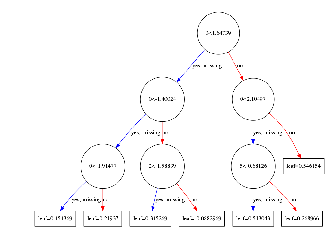

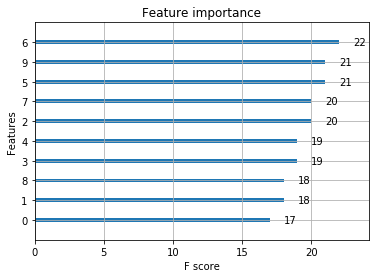

In [46]:
#model_bst = xgb.train(params, d_train, 30, watchlist, early_stopping_rounds=500, verbose_eval=10)
#model_sklearn=clf.fit(X_train, y_train)

#model_bst
plot_tree(model_bst, num_trees=0)
plot_importance(model_bst)
plt.show()

